# Liquidation with Limit and Market Orders Targeting Schedules(Chap 8.5)


This notebook implements the optimal liquidation of an asset using  limit and market orders in a manner that aims to follow a given schedule as discussed in Chapter 8.5 of

Algorithmic and High-Frequency Trading 
(c) Cartea, Jaimungal, & Penalva, 2015 
Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

## Introduction

In Chapter 8.5, Liquidation with Limit and Market Orders, we investigate the optimal strategies followed by a trader who wishes to liquidate shares using both limit and market orders, and simulataneously aims to track a given target inventory schedule. For example, she may be interested in liquidating shares but also in tracking the inventory scheduled followed by TWAP or a schedule such as that implied by the Almgren-Chris strategy.

In this case, the trader's performance criterion is

\begin{equation}
\mathbb E\left[ X_T^{\tau,\delta} + Q_T^{\tau,\delta}(S_T-\xi-\alpha\, Q_T^{\tau,\delta}) - \phi \int_0^T (Q_u^{\tau,\delta}-q_u)^2\,du
\right]
\end{equation}

where $\tau$ represents the set of (stopping) times at which the trader submits market orders, $\delta$ respresents the depth in the limit order book the trader posts their sell limit order, $X^{\tau,\delta}$ is the cash value of the strategy, $q_t$ is the target inventory schedule, and $Q^{\tau,\delta}$ is the trader's inventory.

In particular, the processes appearing above satisfy the SDEs

\begin{equation}
dX_t^{\tau,\delta} = (S_t+\delta_{t^-})\,dN_t^\delta + (S_t-\xi)\,dM_t^\tau
\end{equation}

\begin{equation}
dQ^{\tau,\delta} = -dN_t^\delta - dM_t^\tau
\end{equation}

where $N^\delta$ is the counting process for filled limit orders and $M^\tau$ is the counting process for submitted market orders.

In [1]:
# import pakacges
import numpy as np
import import_ipynb
import LOMO_target_helper as lth

In [2]:
# initial various parameters
T = 60
Ndt = 6000
dt = T / Ndt

t = np.arange(0, T + dt, dt)
tau = T - t

# price jump sizes
sigma = 0.01

kappa = 100
xi = 0.01
alpha = 0.001

lamb = 50 / 60
Nq = 10
phi = 0.001

# AC Solution
phiAC = 10 ** (-5)
aAC = 0.001

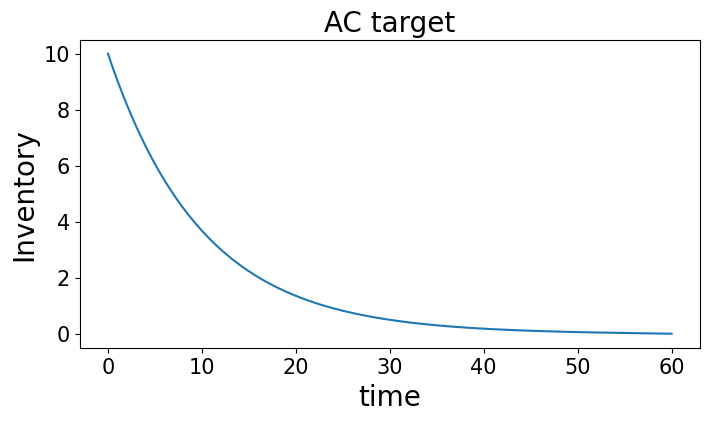

In [3]:
# get the target strategy -- Almgren-Chris in this case

qAC = lth.AC_solver(phiAC, aAC, tau, T, Nq)
lth.plot_curve(t, qAC, xlab ="time", ylab="Inventory", title="AC target")

## Optimal Strategy

In the chapter, we demonstrate that the value function admits a decomposition  the ansatz as $H(t, x, S, q)= x + qS + h(t, q)$, 
where $h$ satisfies the  the quasi-variational inequality ($QVI$) in equation 8.25 in Chapter 8.4:

\begin{equation}
max \Bigg \{ \partial_t h - \phi (q - q_t)^2 + \frac{e^{-1} \lambda}{\kappa} e^{-\kappa [h(t,q) - h(t,q-1 )]} \Bigg \} = 0,
\end{equation}

subject to the terminal and boundary conditions

\begin{equation}
h(T,q) = - \ell(q) \enspace and \enspace 
h(t,0) = \phi \int_t^T q_u^2 du.
\end{equation}

The optimal strategy is given by

\begin{equation}
\delta^{*} = \frac{1}{\kappa} + [h(t,q) - h(t,q - 1)], 
\end{equation}

and the optimal timing $\tau_q$ of MOs (when the trader has $q$ assets)  
is the first time that

\begin{equation}
h(\tau_q, q-1) - h(\tau_q, q) = \xi
\end{equation}

The $QVI$ can be linearised by making the transformation
\begin{equation}
h(t,q) = \tfrac{1}{\kappa} log\, \omega(t,q)
\end{equation}
and we find that $\omega(t,q)$ satisfies  

\begin{equation}
max \Bigg \{ (\partial_t - \kappa \phi (q - q_t)^2) \omega(t, q) + e^{-1}\lambda \omega(t, q-1) \;\textbf{;}\; e^{-\kappa \xi} \omega(t, q-1) - \omega(t, q)  \Bigg \} = 0,
\end{equation}

subject to the terminal and boundary conditions 

\begin{equation}
\omega(T, q) = e^{-\kappa \ell(q)} \enspace and \enspace
\omega(t, 0) = e^{-\kappa \phi \int_t^T q_u^2 du} .
\end{equation}

The solution to this QVI is implemented in the helper file.

## Optimal Strategy enhanced

The $QVI$ can be linearised by making the transformation
\begin{equation}
h(t,q) = \tfrac{1}{\kappa} log\, \omega(t,q)
\end{equation}
and we find that $\omega(t,q)$ satisfies  

\begin{equation}
max \Bigg \{ (\partial_t - \frac{\kappa}{sp(t)} \phi (q - q_t)^2) \omega(t, q) + e^{-1}\lambda_I \omega(t, q-1)+e^{-1+\frac{\kappa}{sp(t)}\alpha_p \lambda_P}\lambda_P \omega(t, q-1) \;\textbf{;}\; e^{-\frac{\kappa}{sp(t)} \xi(t)} \omega(t, q-1) - \omega(t, q)  \Bigg \} = 0,
\end{equation}
where
$$ \xi=sp(t)+\alpha_A \lambda_A(t), $$
$$ \lambda_A(t)=\frac{E[N^A_{T-t}]}{T-t}, $$

subject to the terminal and boundary conditions 

\begin{equation}
\omega(T, q) = e^{-\kappa \ell(q)} \enspace and \enspace
\omega(t, 0) = e^{-\kappa \phi \int_t^T q_u^2 du} .
\end{equation}

The solution to this QVI is implemented in the helper file.

In [20]:
# Inventory q Vector
q = np.arange(0, Nq + 1, 1)

# solve the QVI for omega
omega, exe = lth.hjb_solver(t, dt, kappa, xi, phi, q, qAC, lamb)

# obtain the optimal time at which to execute market orders
t_opt = lth.find_opt_t(exe, t)

# Solve for delta
delta = lth.find_delta(kappa, omega, Nq, Ndt)

In [ ]:
q = np.arrange(0, Nq + 1, 1)
sigma_t = np.full(Ndt, sigma)
lamb_P = 50/60
lamb_I = 40/60
alpha_P = 0.0001
alpha_A = 0.00003

# solve the QVI for omega
omega2, exe2 = lth.hjb_solver_market_impact(t, dt, kappa, xi, phi, q, qAC, sigma_t, lamb_P, lamb_I, alpha_P, alpha_A)

# obtain the optimal time at which to execute market orders
t_opt = lth.find_opt_t(exe2, t)

# Solve for delta
delta = lth.find_delta(kappa, omega2, Nq, Ndt)

Below, for each inventory level, we plot the time $\tau_q$ at which the trader should submit a market order together with the target schedule $q_t$. For example, the trader currently has 4 assets, they will post a limit order but  if it is not filled by $t\sim20sec$, then they execute a market order.

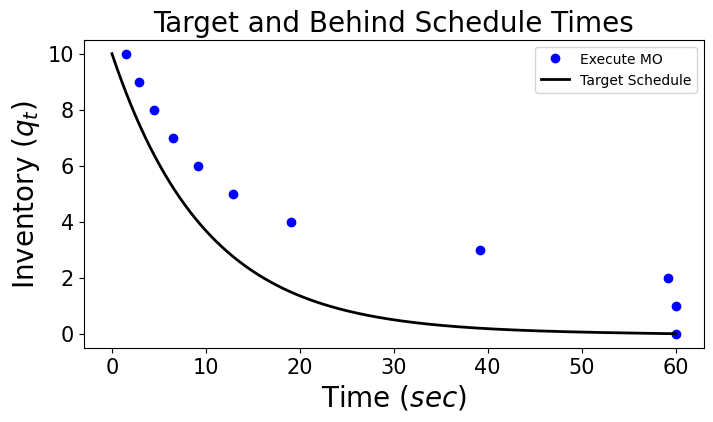

In [5]:
# plot the results
lth.plot_topt(t_opt, q, qAC, t)

Next, for each inventory level, we plot the optimal depth $\delta_t$ as a function of time.

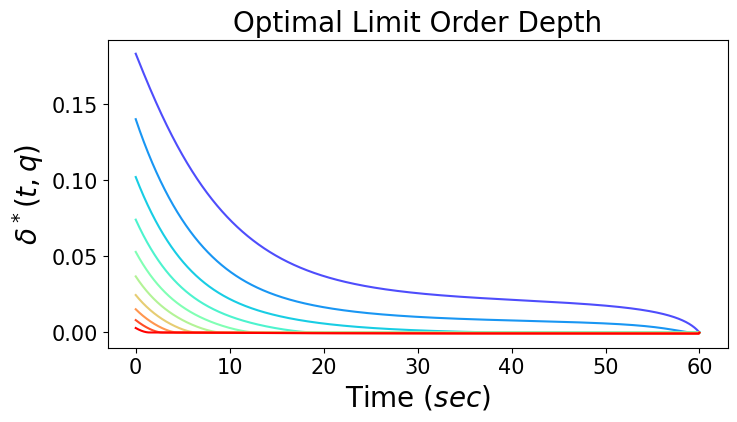

In [6]:
lth.plot_multi_lines(t[0:(t.shape[0]-1)], delta[:, 0:(delta.shape[1]-1)],  xlab=r"Time ($sec$)", ylab=r"$\delta^*(t,q)$", title=r"Optimal Limit Order Depth")

## Simulation
Next, we simulate sample paths and the trader's optimal behaviour along those paths. To this we
* obtain the optimal limit order price for the current inventory and post it
* check  whether we are behind schedule ($t>\tau_q$) and if so execute a market order, and cancel the limit order
* step forward in time
  * update the price
  * check whether an incoming market order arrives
  * if a market order arrives, check if your limit order is filled
  * update cash and inventory

In this simulation, we use the parameters

\begin{equation}
t = 60 sec
\quad 
\lambda = 50 / min
\quad
\kappa = 100
\quad 
\sigma = 0.01
\quad
\alpha = 0.001
\quad
\xi = 0.01
\end{equation}

In [7]:
np.random.seed(30)

# Number of Simulations
Nsims = 1000

# The Mid-price to start with
s0 = 1

deltaPath, Qpath, isMO, Xpath, Spath, pricePerShare, twap = lth.generate_simulations(Nsims, s0, Ndt, Nq, dt, delta, lamb, kappa, sigma, xi, t_opt, t)

# Choose the three simulation results
idx_fig = np.array([382, 57, 1])

Visualize Depth vs Time (sec) of the simulations.

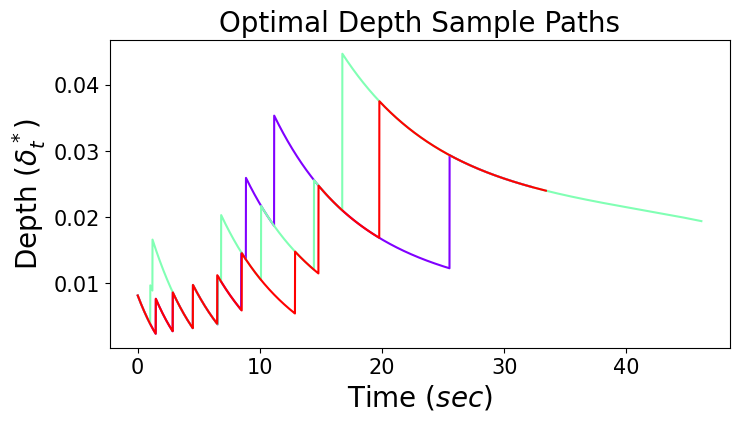

In [8]:
lth.plot_multi_lines(t, deltaPath[idx_fig, :], r'Time ($sec$)', r'Depth ($\delta^*_t$)', r'Optimal Depth Sample Paths')

Visualize Intensity vs Time (sec) of the simulations.

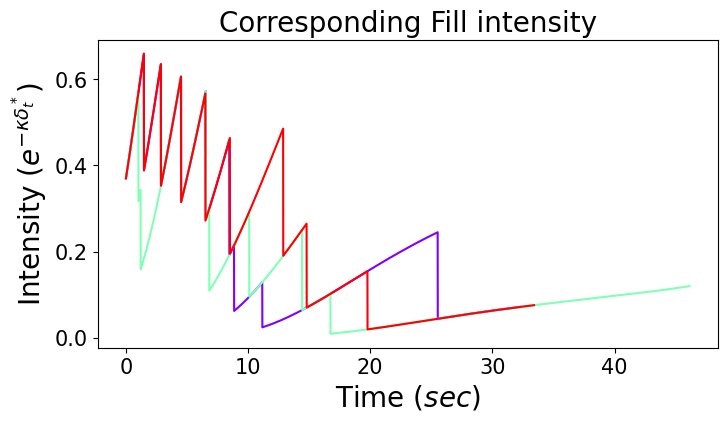

In [9]:
intensity = lamb * np.exp(-kappa * deltaPath[idx_fig, :])

lth.plot_multi_lines(t, intensity, r'Time ($sec$)', r'Intensity ($e^{-\kappa\delta_t^*}$)', r'Corresponding Fill intensity')

Visualize Inventory vs Time (sec) of the simulations. The blue dots indicates whether it is a market order.

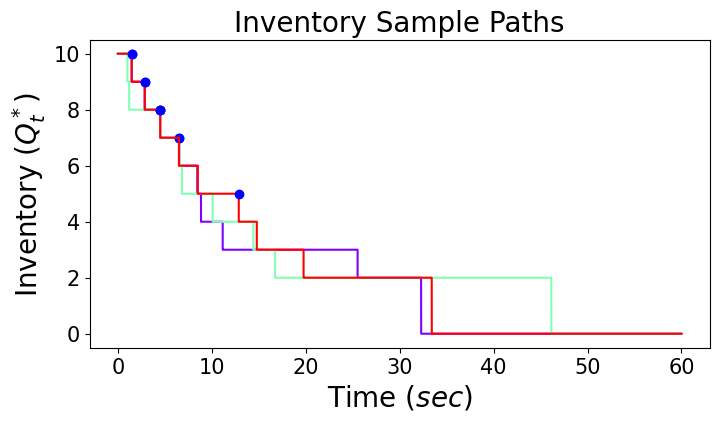

In [10]:
lth.plot_inventory(isMO[idx_fig, :], Qpath[idx_fig, :], t)

Visualize Cash vs Time (sec) of the simulations.

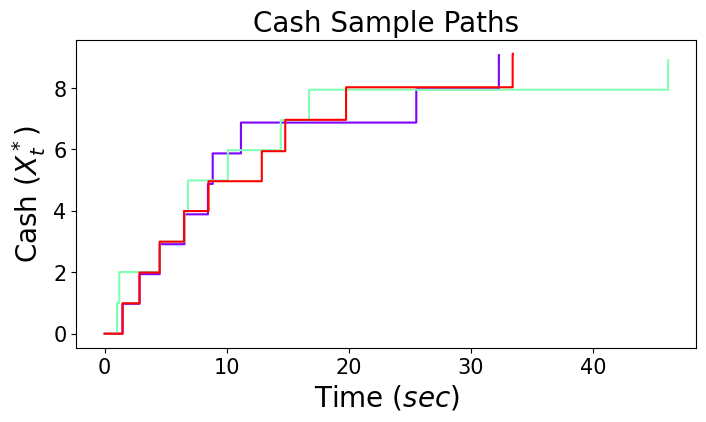

In [11]:
lth.plot_multi_steps(t, Xpath[idx_fig, :], r'Time ($sec$)', r'Cash ($X^*_t$)',r'Cash Sample Paths')

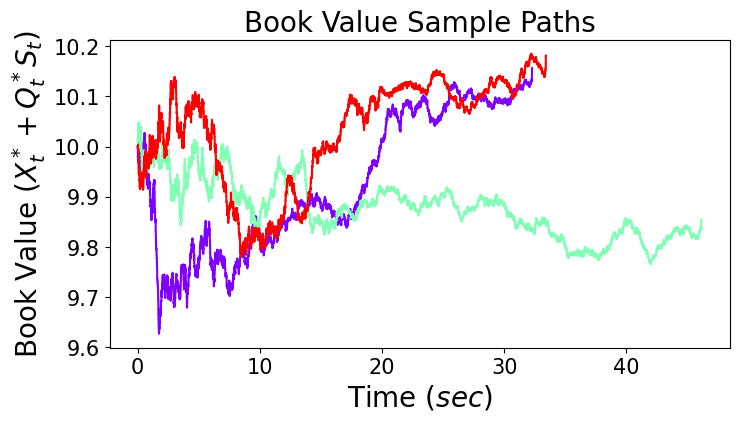

In [12]:
lth.plot_multi_steps(t, Xpath[idx_fig, :]+Qpath[idx_fig,:] * Spath[idx_fig,:], r'Time ($sec$)', r'Book Value ($X^*_t+Q^*_tS_t$)',r'Book Value Sample Paths')

Visualize Mid-price vs Time (sec) of the simulations.

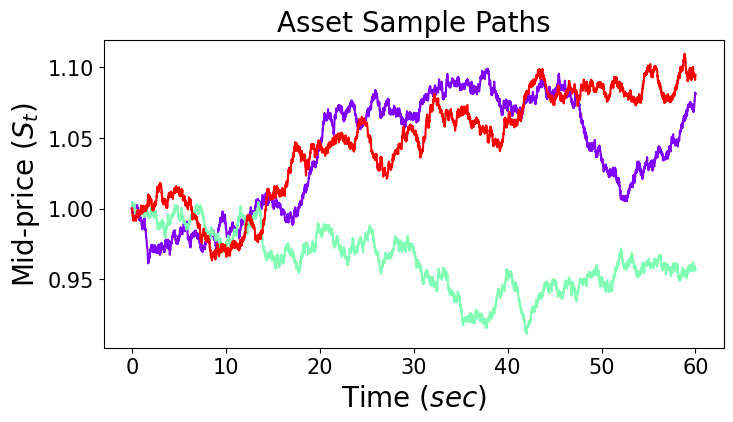

In [13]:
lth.plot_multi_lines(t, Spath[idx_fig, :], r'Time ($sec$)', r'Mid-price ($S_t$)',r'Asset Sample Paths')

Visualize Price Per Share vs Time (sec) of the simulation.

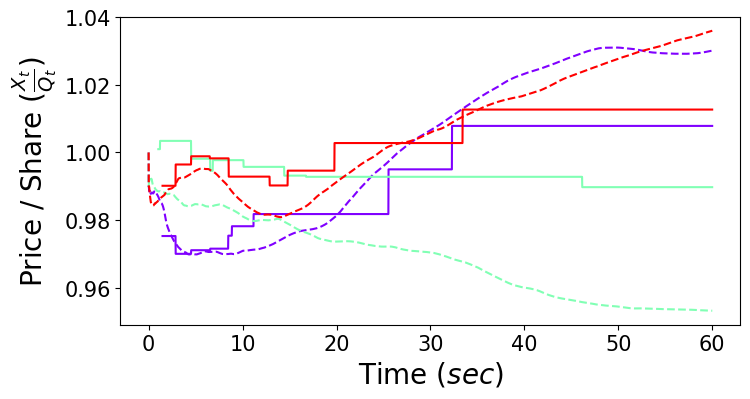

In [14]:
lth.plot_price_per_share(t, pricePerShare[idx_fig, :], twap[idx_fig, :])

/var/folders/6j/0rnv84rj5430vggksr33c1880000gn/T/ipykernel_86783/3303023187.py:1: RuntimeWarning: invalid value encountered in divide
  pricepershare = np.divide(Xpath, Nq - Qpath)


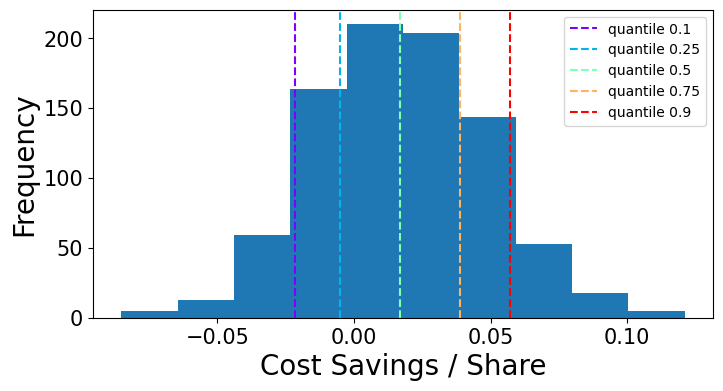

In [15]:
pricepershare = np.divide(Xpath, Nq - Qpath)
idx = np.sum(lth.nan_to_num(pricepershare, 0), axis=1).astype(int)

terminal_pps = np.full(pricepershare.shape[0], np.NaN)
for i in range(0, terminal_pps.shape[0], 1):   
    if idx[i] > pricepershare.shape[1] - 1:
        terminal_pps[i] = np.NaN
    else:
        terminal_pps[i] = pricepershare[i, idx[i]]

lth.plot_histogram(terminal_pps - twap[:, twap.shape[1] - 1], r'Cost Savings / Share', np.array([0.1, 0.25, 0.5, 0.75, 0.9]))

Visualize the histogram of the number of MOs of each simulation.

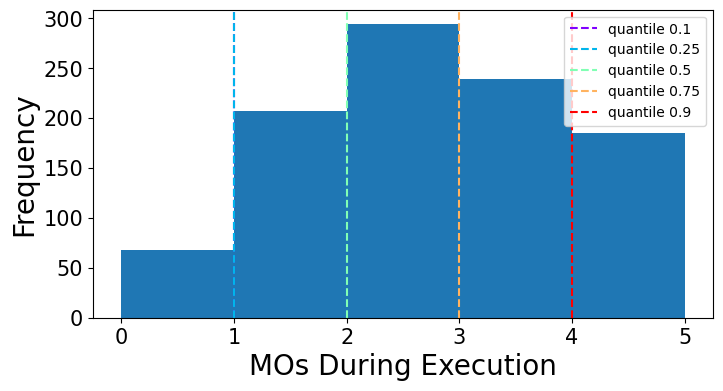

In [16]:
# figure(201)
totalMO = np.sum(isMO, axis=1)
lth.plot_histogram(totalMO, r'MOs During Execution', np.array([0.1, 0.25, 0.5, 0.75, 0.9]), bins=np.arange(0,np.ceil(np.quantile(totalMO,0.999)),1) )

Visualize the histogram of the inventory at the end of each simulation.

AttributeError: module 'matplotlib.ticker' has no attribute '_mathdefault'

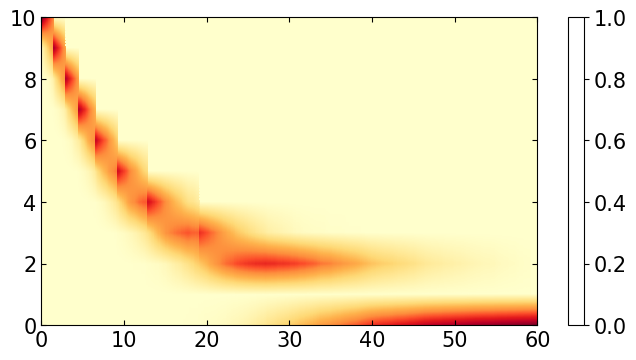

In [17]:
# figure(203)
q = np.arange(0, Nq + 1, 1)
myn = np.full((Ndt + 1, Nq + 1), np.NaN)
for k in range(0, t.shape[0], 1):
    myn[k, :]  = np.histogram(Qpath[:, k], bins=np.append(q, Nq + 1))[0]
myn = np.transpose(myn)
medq = np.median(Qpath, axis=0)
meanq = np.mean(Qpath, axis=0)

lth.plot_heat_map(t=t, q=q, myn_per_sim=myn / Nsims, meanq=meanq, medq=medq, qAC=qAC, xlab=r'Time (sec)', ylab=r'Inventory',title=r'Inventory Heatmap')